<a href="https://colab.research.google.com/github/arkarmk/Credit-Card-Fraud-Detection-Project/blob/main/CreditCardFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Credit Card Fraud Detection (From Kaggle)**
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

###**Context:**

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

###**Content:**

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

##**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax
from scipy.special import boxcox1p

import sklearn
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, average_precision_score, precision_recall_curve

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# to ingore warnings
import warnings
warnings.filterwarnings("ignore")

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Exploratory Data Analysis (EDA)**

In [2]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/Projects/Credit Card Fraud Detection/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print(df.shape)
print('-'*60)
print(f'Null values:{df.isnull().values.sum()}')
print('-'*60)
print(df.info())
print('-'*60)
print(df.describe())

(284807, 31)
------------------------------------------------------------
Null values:0
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     28480

Non Fraudulent: 284315
Fraudulent: 492


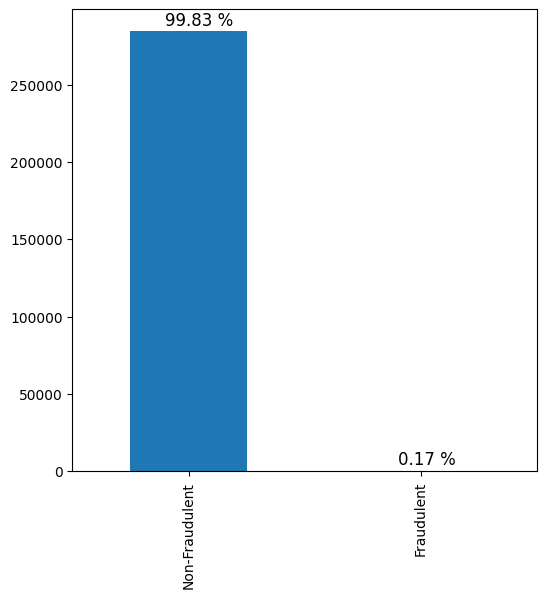

In [ ]:
# Check the distribution of class (target variable)
class_counts = df['Class'].value_counts()

for index, count in class_counts.iteritems():
  label = "Non Fraudulent" if index == 0 else "Fraudulent"
  print(f"{label}: {count}")

# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
normal_share=class_counts[0]/df['Class'].count()*100
fraud_share=class_counts[1]/df['Class'].count()*100

ax = class_counts.plot(kind='bar', figsize=(6,6), tick_label=['Non Fraudulent','Fraudulent'])
plt.xticks(ticks=[0,1], labels=['Non-Fraudulent','Fraudulent'])
plt.text(x=-0.10, y=class_counts[0] + 4000, s=str(round(normal_share, 2)) + ' %', size=12)
plt.text(x=0.9, y=class_counts[1] + 4000, s=str(round(fraud_share, 2)) + ' %', size = 12)
plt.show()

As expected, this dataset is imbalanced with more instances of non fraudulant transcations.

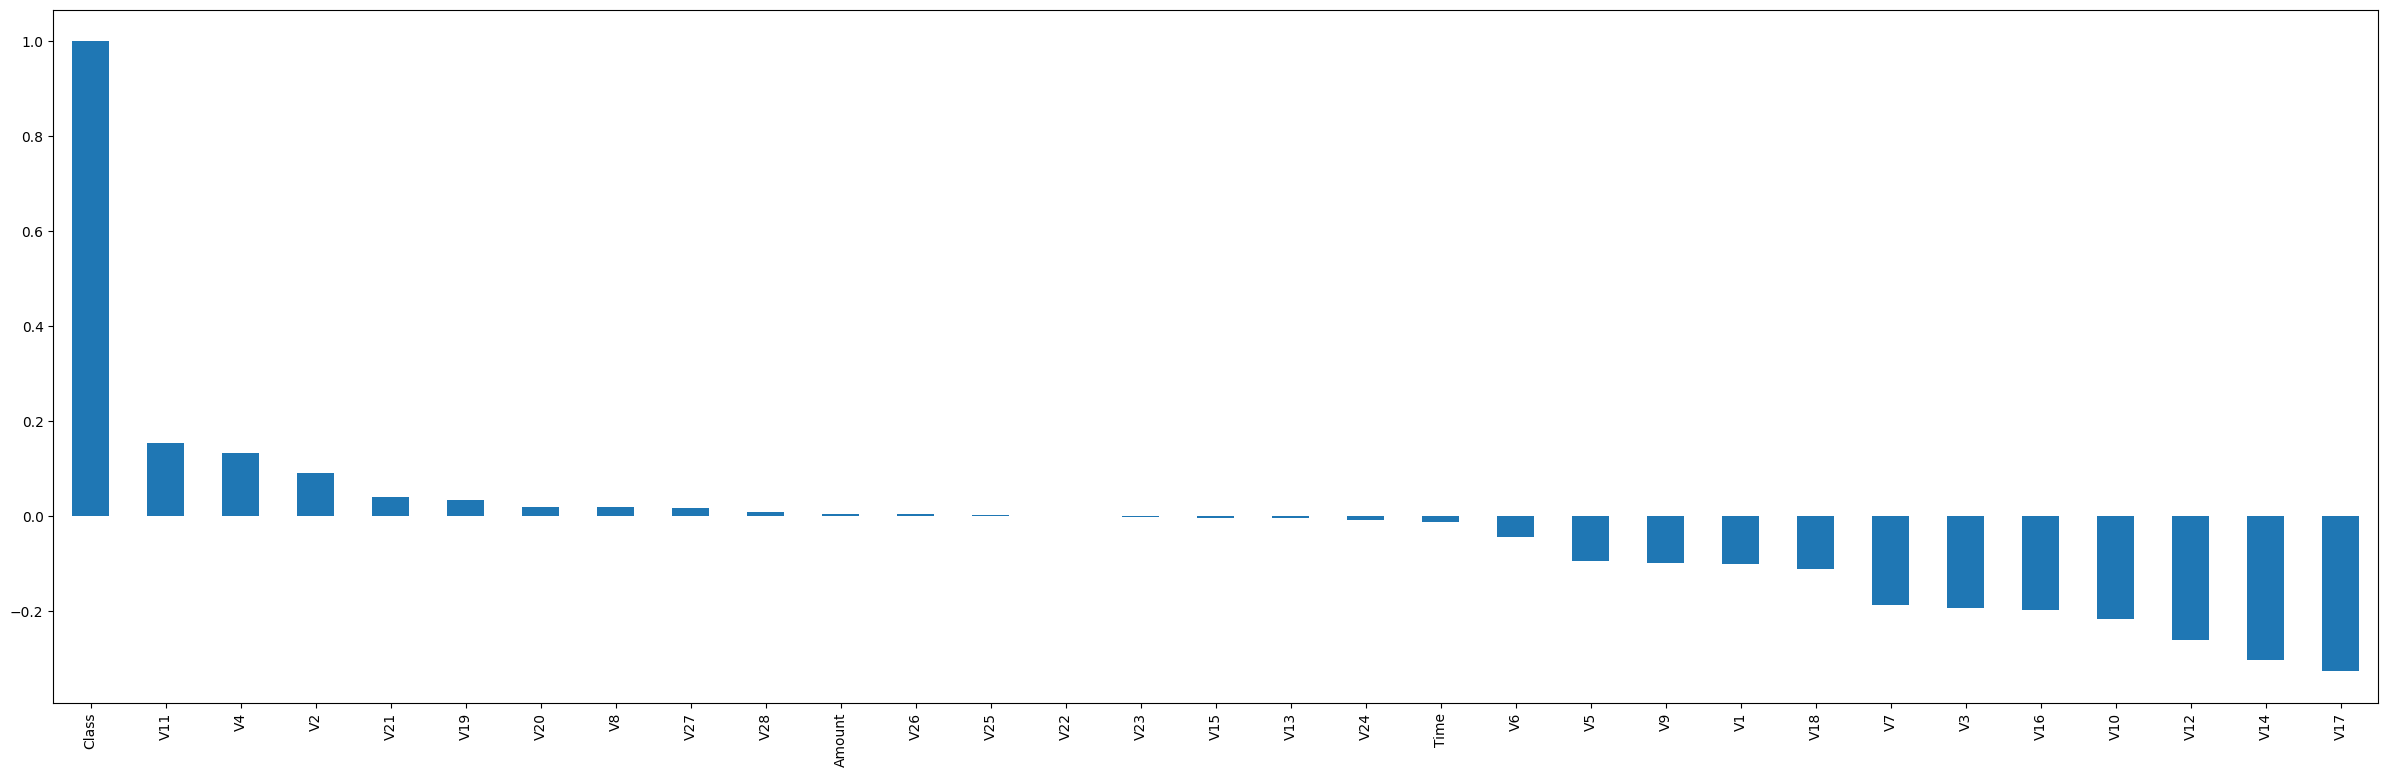

In [ ]:
#Get Correlation of "Class" with other variables:
plt.figure(figsize=(30,9))
df.corr()['Class'].sort_values(ascending = False).plot(kind = 'bar')
plt.show()



*   Class is highly positively correlated to V11, V4 and V2
*   Class is highly negatively correlated to V17, V14 and V12

##**Feature Engineering**

In [3]:
# As time is given in a relative function, we use pandas.timedelta which represents a duration, the difference between two time
Delta_Time = pd.to_timedelta(df["Time"],unit='s')

# Create derived columns Mins and Hours
df['Time_Day'] = (Delta_Time.dt.components.days).astype(int)
df['Time_Hour'] = (Delta_Time.dt.components.hours).astype(int)
df['Time_Min'] = (Delta_Time.dt.components.minutes).astype(int)

# Drop unwanted columns
df.drop(['Time','Time_Day','Time_Min'], axis = 1, inplace =True) # day/mins might not be very useful

##**Split the dataset into Train and Test sets**

In [4]:
y = df['Class'] # variable of interest
X = df.drop(['Class'], axis = 1) # features

In [5]:
# Split dataset using train test split
# Preserve the X_test and y_test to evaluate the model later
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=100, test_size=0.2)

In [ ]:
# Check the speard of the data after splitting
print('Y:',np.sum(y))
print('Y train:',np.sum(y_train))
print('Y test:',np.sum(y_test))

Y: 492
Y train: 396
Y test: 96


Plotting the distribution of a feature

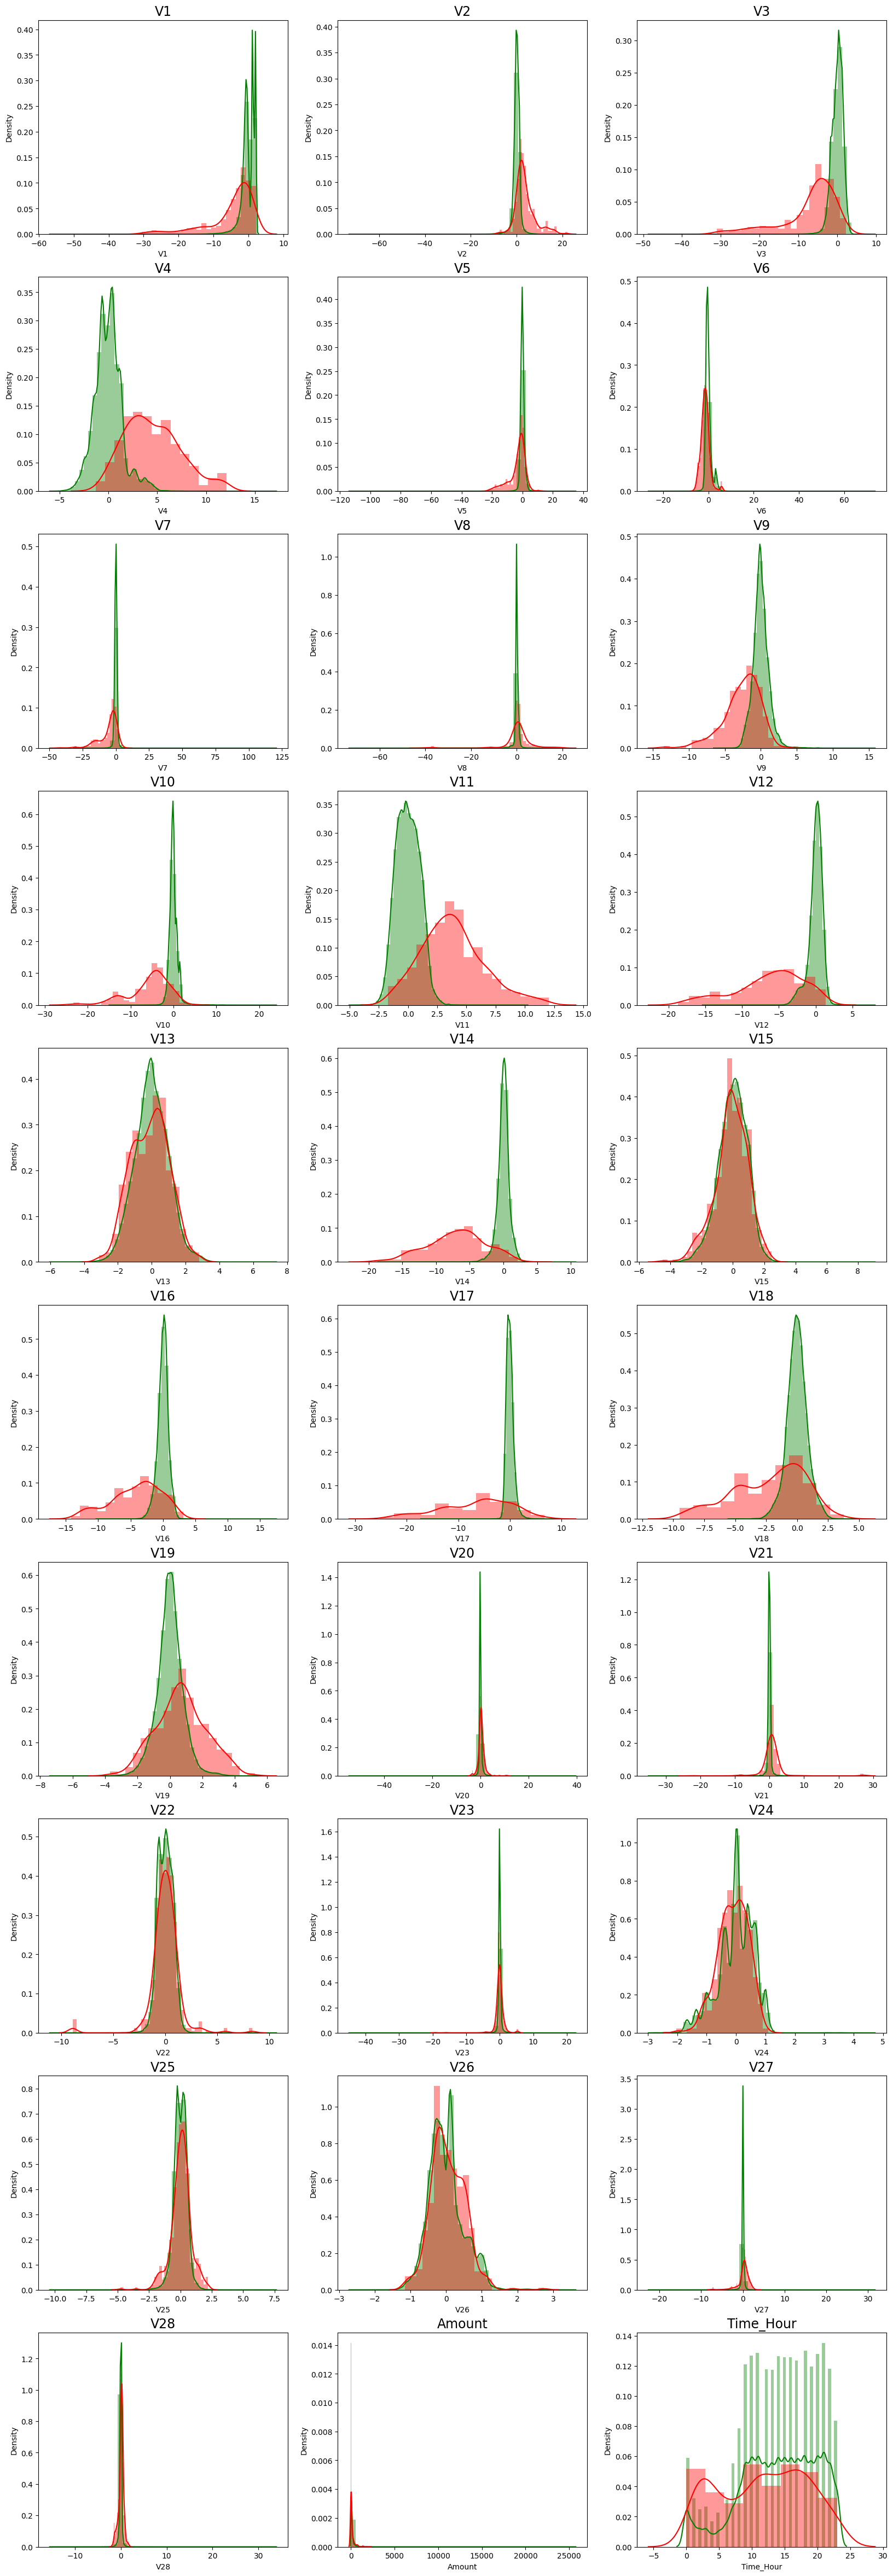

In [ ]:
# Accumulating all the feature names under one variable
cols = list(X.columns.values)

# plot the histogram for features from the dataset to observe the skewness
normal_records = df.Class == 0
fraud_records = df.Class == 1

plt.figure(figsize=(20,60))
for i, f in enumerate(cols):
  plt.subplot(10,3,i+1)
  sns.distplot(X[f][normal_records], color='green')
  sns.distplot(X[f][fraud_records], color='red')
  plt.title(f, fontsize=17)
plt.show()

##**Model Building with imbalanced data**

###**Create common functions for Models**

In [ ]:
df_imbalanced_results = pd.DataFrame(columns=['Methodology','Model','Accuracy','PR_AUC','threshold'])

In [9]:
# Create a common function to plot confusion matrix
def plot_confusion_matrix(y_test, pred_test):
  cm = confusion_matrix(y_test, pred_test)
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
  categoryNames = ['Non-Fraudalent','Fraudalent']
  plt.title('Confusion Matrix - Test Data')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  ticks = np.arange(len(categoryNames))
  plt.xticks(ticks, categoryNames, rotation=45)
  plt.yticks(ticks, categoryNames)
  s = [['TN','FP'],['FN','TP']]

  for i in range(2):
    for j in range(2):
      plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 12)
  plt.show()

In [ ]:
# Create a common function to fit and predict on a Logistic Regression model for both L1 and L2
def imbalanced_buildAndRunLogisticModels(df_imbalanced_results, Methodology, X_train, y_train, X_test, y_test):

  # Logistic Regression
  from sklearn import linear_model
  from sklearn.model_selection import KFold

  num_C = list(np.power(10.0, np.arange(-10,10)))
  cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

  searchCV_l2 = linear_model.LogisticRegressionCV(
      Cs= num_C,
      penalty='l2',
      scoring='average_precision',
      cv=cv_num,
      random_state=42,
      max_iter=10000,
      fit_intercept=True,
      solver='newton-cg',
      tol=10
  )

  searchCV_l1 = linear_model.LogisticRegressionCV(
      Cs=num_C,
      penalty='l1',
      scoring='average_precision',
      cv=cv_num,
      random_state=42,
      max_iter=10000,
      fit_intercept=True,
      solver='liblinear',
      tol=10
  )

  searchCV_l1.fit(X_train,y_train)
  searchCV_l2.fit(X_train,y_train)

  # Find predicted values
  y_pred_l1 = searchCV_l1.predict(X_test)
  y_pred_l2 = searchCV_l2.predict(X_test)

  # Find predicted probabilities
  y_pred_probs_l1 = searchCV_l1.predict_proba(X_test)[:,1]
  y_pred_probs_l2 = searchCV_l2.predict_proba(X_test)[:,1]

  # Accuracy of L2/L1 models
  Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
  Accuracy_l1 = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)

  print('Accuracy of Logistic model with l2 regularisation : {0}'.format(Accuracy_l2))
  print('Confusion Matrix')
  plot_confusion_matrix(y_test,y_pred_l2)
  print('Classification Report')
  print(classification_report(y_test,y_pred_l2))

  print('Accuracy of Logistic model with l1 regularisation : {0}'.format(Accuracy_l1))
  print('Confusion Matrix')
  plot_confusion_matrix(y_test,y_pred_l1)
  print('Classification Report')
  print(classification_report(y_test,y_pred_l1))

  # PR_AUC for L2 model
  precision_l2, recall_l2, thresholds = precision_recall_curve(y_test, y_pred_probs_l2)
  pr_auc_l2 = auc(recall_l2, precision_l2)
  # Calculate F1 score for each threshold
  f1_scores_l2 = 2 * (precision_l2 * recall_l2) / (precision_l2 + recall_l2)
  # Find the threshold that maximizes the F1 score
  threshold_l2 = thresholds[np.argmax(f1_scores_l2)]

  print("PR AUC for Logistic model with L2 regularization: {0}".format(pr_auc_l2))
  print("Threshold for L2 model: {0}".format(threshold_l2))
  df_imbalanced_results = df_imbalanced_results.append(pd.DataFrame({'Methodology': Methodology, 'Model': 'Logistic Regression with L2 Regularization', 'Accuracy': Accuracy_l2, 'PR_AUC': pr_auc_l2, 'threshold': threshold_l2}, index=[0]), ignore_index=True)

  # PR_AUC for L1 model
  precision_l1, recall_l1, thresholds = precision_recall_curve(y_test, y_pred_probs_l1)
  pr_auc_l1 = auc(recall_l1, precision_l1)
  # Calculate F1 score for each threshold
  f1_scores_l1 = 2 * (precision_l1 * recall_l1) / (precision_l1 + recall_l1)
  # Find the threshold that maximizes the F1 score
  threshold_l1 = thresholds[np.argmax(f1_scores_l2)]

  print("PR AUC for Logistic model with L1 regularization: {0}".format(pr_auc_l1))
  print("Threshold for L1 model: {0}".format(threshold_l1))
  df_imbalanced_results = df_imbalanced_results.append(pd.DataFrame({'Methodology': Methodology, 'Model': 'Logistic Regression with L1 Regularization', 'Accuracy': Accuracy_l1, 'PR_AUC': pr_auc_l1, 'threshold': threshold_l1}, index=[0]), ignore_index=True)

  return df_imbalanced_results

In [ ]:
# Create a common function to fit and predict on a KNN model
def imbalanced_buildAndRunKNNModels(df_imbalanced_results,Methodology,X_train,y_train,X_test,y_test):

  #create KNN model and fit model with train set
  knn = KNeighborsClassifier(n_neighbors=5, n_jobs=16)
  knn.fit(X_train,y_train)

  #accuracy
  y_pred=knn.predict(X_test)
  KNN_Accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)
  print('Confusion Matrix')
  plot_confusion_matrix(y_test,y_pred)
  print('Classification Report')
  print(classification_report(y_test,y_pred))

  # Calculate precision-recall curve values
  precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_test, knn.predict_proba(X_test)[:, 1])

  # PR AUC for KNN model
  knn_pr_auc = auc(recall_knn, precision_knn)
  print(f'KNN PR AUC: {knn_pr_auc}')

  # Find the threshold for maximum F1 score
  threshold_knn = thresholds_knn[np.argmax(2 * (precision_knn * recall_knn) / (precision_knn + recall_knn))]
  print(f'KNN Threshold: {threshold_knn}')

  df_imbalanced_results = df_imbalanced_results.append(pd.DataFrame({'Methodology': Methodology, 'Model': 'KNN', 'Accuracy': KNN_Accuracy, 'PR_AUC': knn_pr_auc, 'threshold': threshold_knn}, index=[0]), ignore_index=True)

  return df_imbalanced_results

In [ ]:
# Create a common function to fit and predict on a DecisionTreeModel for both gini and entropy criteria
def imbalanced_buildAndRunTreeModels(df_imbalanced_results,Methodology,X_train,y_train,X_test,y_test):
  #Evaluate Decision Tree model with 'gini' and 'entropy'
  criteria = ['gini','entropy']

  for c in criteria:
    dt = DecisionTreeClassifier(criterion=c, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    test_score = dt.score(X_test,y_test)

    print(c + f" score: {test_score}")
    print('Confusion Matrix')
    plot_confusion_matrix(y_test, y_pred)
    print('Classification Report')
    print(classification_report(y_test, y_pred))

    # Calculate precision-recall curve values
    precision_tree, recall_tree, thresholds_tree = precision_recall_curve(y_test, dt.predict_proba(X_test)[:, 1])

    # PR AUC for Decision Tree model
    tree_pr_auc = auc(recall_tree, precision_tree)
    print(f"DecisionTree Model with {c} criteria PR AUC: {tree_pr_auc}")

    # Find the threshold for maximum F1 score
    threshold_tree = thresholds_tree[np.argmax(2 * (precision_tree * recall_tree )/ (precision_tree + recall_tree))]
    print(f"DecisionTree Model with {c} criteria Threshold: {threshold_tree}")

    df_imbalanced_results = df_imbalanced_results.append(pd.DataFrame({'Methodology': Methodology, 'Model': f'DecisionTree Model with {c} criteria', 'Accuracy': test_score, 'PR_AUC': tree_pr_auc, 'threshold': threshold_tree}, index=[0]), ignore_index=True)

  return df_imbalanced_results

In [ ]:
# Create a common function to fit and predict on a Random Forest Model
def imbalanced_buildAndRunRandomForestModels(df_imbalanced_results,Methodology,X_train,y_train,X_test,y_test):
  # Evaluate Random Forest Model

  #create the model with 100 trees
  RF_model = RandomForestClassifier(
      n_estimators=100,
      bootstrap = True,
      max_features = 'sqrt', random_state=42)

  #fIt on training data
  RF_model.fit(X_train,y_train)
  RF_test_score= RF_model.score(X_test,y_test)

  print(f'Model Accuracy: {RF_test_score}')

  # Actual class predictions
  rf_predictions = RF_model.predict(X_test)

  print("Confusion Matrix")
  plot_confusion_matrix(y_test, rf_predictions)
  print('Classification Report')
  print(classification_report(y_test,rf_predictions))

  #Probabilities for each class
  rf_probs = RF_model.predict_proba(X_test)[:,1]

  # Calculate precision-recall curve values
  precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf_probs)

  # PR AUC for Random Forest model
  rf_pr_auc = auc(recall_rf, precision_rf)
  print(f"Random Forest PR AUC: {rf_pr_auc}")

  # Find the threshold for maximum F1 score
  threshold_rf = thresholds_rf[np.argmax(2 * (precision_rf * recall_rf) / (precision_rf + recall_rf))]
  print(f"Random Forest Threshold: {threshold_rf}")

  df_imbalanced_results = df_imbalanced_results.append(pd.DataFrame({'Methodology': Methodology, 'Model': 'Random Forest', 'Accuracy': RF_test_score, 'PR_AUC': rf_pr_auc, 'threshold': threshold_rf}, index=[0]), ignore_index=True)

  return df_imbalanced_results

In [ ]:
# Create a common function to fit and predict on a XGBoost model
def imbalanced_buildAndRunXGBoostModels(df_imbalanced_results,Methodology,X_train,y_train,X_test,y_test):
  #Evaluate XGBoost model
  XGBmodel= XGBClassifier(random_state=42)
  XGBmodel.fit(X_train,y_train)
  y_pred = XGBmodel.predict(X_test)

  XGB_test_score = XGBmodel.score(X_test, y_test)
  print(f'Model Accuracy: {XGB_test_score}')

  print('Confusion Matrix')
  plot_confusion_matrix(y_test,y_pred)
  print("Classification Report")
  print(classification_report(y_test,y_pred))

  #Probabilities for each class
  XGB_probs = XGBmodel.predict_proba(X_test)[:,1]

  #Calculate precision-recall curve values
  precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, XGB_probs)

  # PR AUC for XGBoost model
  xgb_pr_auc = auc(recall_xgb, precision_xgb)
  print(f'XGBoost PR AUC: {xgb_pr_auc}')

  # Find the threshold for maximum F1 score
  threshold_xgb = thresholds_xgb[np.argmax(2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb))]
  print(f'XGBoost Threshold: {threshold_xgb}')

  df_imbalanced_results = df_imbalanced_results.append(pd.DataFrame({'Methodology': Methodology, 'Model': 'XGBoost', 'Accuracy': XGB_test_score, 'PR_AUC': xgb_pr_auc, 'threshold': threshold_xgb}, index=[0]), ignore_index=True)


  return df_imbalanced_results

###**Perform Cross Validation with StratifiedKFold**

In [6]:
# Perform stratifiedKFold and check the results
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None)
# X is the features and y is the target
for train_index, test_index in skf.split(X,y):
  print('TRAIN:',train_index, "TEST:", test_index)
  X_train_SKF_cv, X_test_SKF_cv = X.iloc[train_index], X.iloc[test_index]
  y_train_SKF_cv, y_test_SKF_cv = y.iloc[train_index], y.iloc[test_index]

TRAIN: [ 30473  30496  31002 ... 284804 284805 284806] TEST: [    0     1     2 ... 57017 57018 57019]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 30473  30496  31002 ... 113964 113965 113966]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 81609  82400  83053 ... 170946 170947 170948]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [150654 150660 150661 ... 227866 227867 227868]
TRAIN: [     0      1      2 ... 227866 227867 227868] TEST: [212516 212644 213092 ... 284804 284805 284806]


###**Run Models**

Logistic Regression with L1 and L2 regularisation
Accuracy of Logistic model with l2 regularisation : 0.9990344270641316
Confusion Matrix


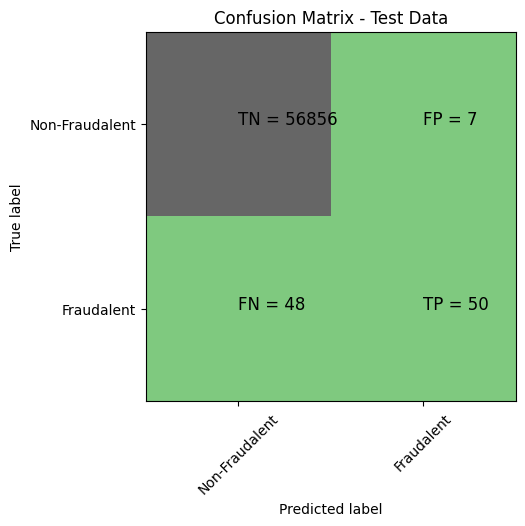

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.88      0.51      0.65        98

    accuracy                           1.00     56961
   macro avg       0.94      0.76      0.82     56961
weighted avg       1.00      1.00      1.00     56961

Accuracy of Logistic model with l1 regularisation : 0.9987535331191517
Confusion Matrix


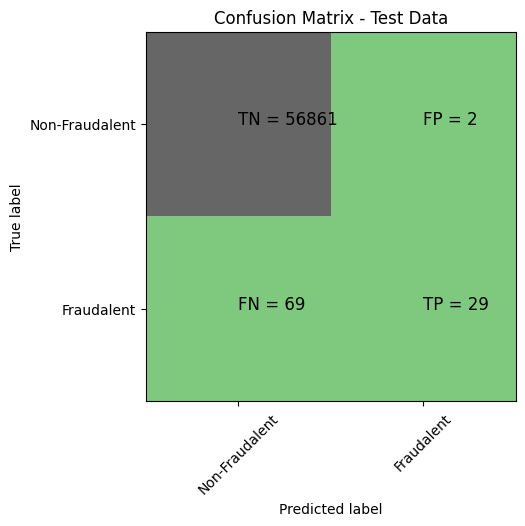

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.97      0.65      0.72     56961
weighted avg       1.00      1.00      1.00     56961

PR AUC for Logistic model with L2 regularization: 0.7441168465718009
Threshold for L2 model: 0.09090702690731521
PR AUC for Logistic model with L1 regularization: 0.6902550206118807
Threshold for L1 model: 0.034967000246256916
Time taken by model: ---479.75170636177063 seconds
------------------------------------------------------------
KNN Model
Confusion Matrix


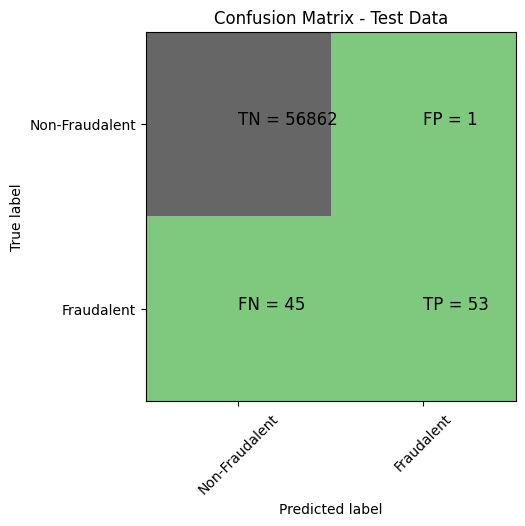

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.98      0.54      0.70        98

    accuracy                           1.00     56961
   macro avg       0.99      0.77      0.85     56961
weighted avg       1.00      1.00      1.00     56961

KNN PR AUC: 0.6696330182911826
KNN Threshold: 0.4
Time taken by model: ---155.50244402885437 seconds
------------------------------------------------------------
Decision Tree Models with gini and entropy criteria
gini score: 0.998841312476958
Confusion Matrix


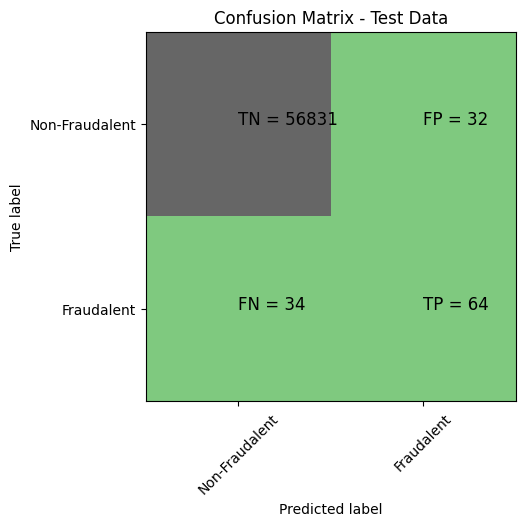

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.67      0.65      0.66        98

    accuracy                           1.00     56961
   macro avg       0.83      0.83      0.83     56961
weighted avg       1.00      1.00      1.00     56961

DecisionTree Model with gini criteria PR AUC: 0.6601623953947724
DecisionTree Model with gini criteria Threshold: 1.0
entropy score: 0.9990168711925703
Confusion Matrix


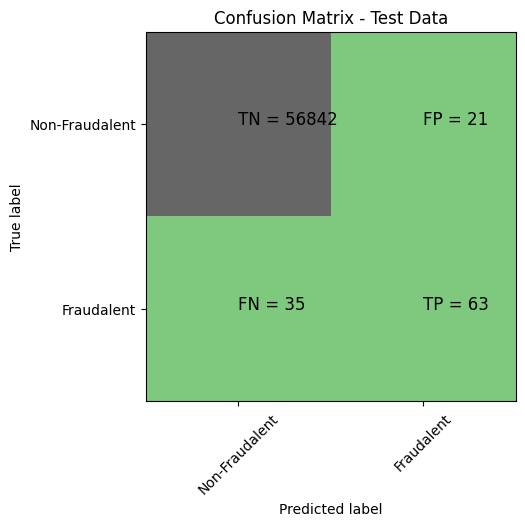

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.75      0.64      0.69        98

    accuracy                           1.00     56961
   macro avg       0.87      0.82      0.85     56961
weighted avg       1.00      1.00      1.00     56961

DecisionTree Model with entropy criteria PR AUC: 0.6967357991808931
DecisionTree Model with entropy criteria Threshold: 1.0
Time taken by model: ---41.39674663543701 seconds
------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


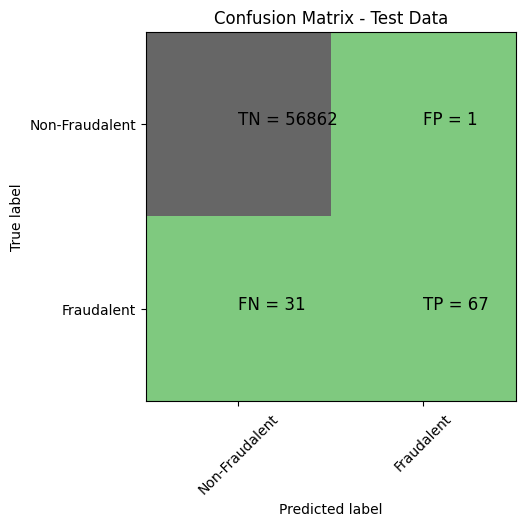

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.68      0.81        98

    accuracy                           1.00     56961
   macro avg       0.99      0.84      0.90     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest PR AUC: 0.8087322141170125
Random Forest Threshold: 0.47
Time taken by model: ---284.41697788238525 seconds
------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


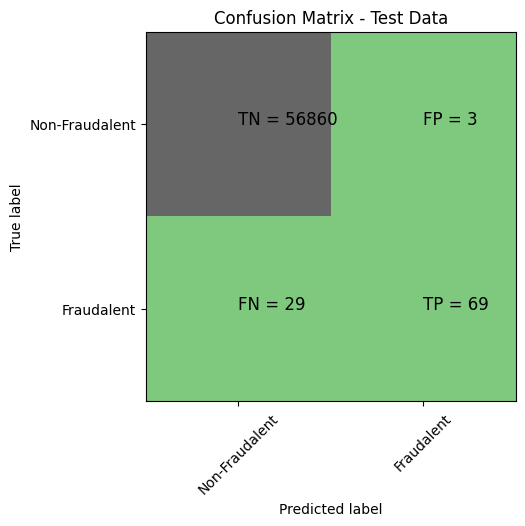

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.96      0.70      0.81        98

    accuracy                           1.00     56961
   macro avg       0.98      0.85      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost PR AUC: 0.7850345989901083
XGBoost Threshold: 0.29899072647094727
Time taken by model: ---7.633319139480591 seconds


,Methodology,Model,Accuracy,PR_AUC,threshold
5,StratifiedKFold CV,Random Forest,0.999438,0.808732,0.470000
6,StratifiedKFold CV,XGBoost,0.999438,0.785035,0.298991
0,StratifiedKFold CV,Logistic Regression with L2 Regularization,0.999034,0.744117,0.090907
4,StratifiedKFold CV,DecisionTree Model with entropy criteria,0.999017,0.696736,1.000000
1,StratifiedKFold CV,Logistic Regression with L1 Regularization,0.998754,0.690255,0.034967
2,StratifiedKFold CV,KNN,0.999192,0.669633,0.400000
3,StratifiedKFold CV,DecisionTree Model with gini criteria,0.998841,0.660162,1.000000


In [ ]:
# Run Logistic Regression with L1 and L2 regularisation
print('Logistic Regression with L1 and L2 regularisation')
start_time= time.time()
df_imbalanced_results = imbalanced_buildAndRunLogisticModels(df_imbalanced_results,"StratifiedKFold CV", X_train_SKF_cv, y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run KNN Model
print('KNN Model')
start_time= time.time()
df_imbalanced_results = imbalanced_buildAndRunKNNModels(df_imbalanced_results,"StratifiedKFold CV", X_train_SKF_cv, y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Decision Tree Models with gini and entropy criteria
print('Decision Tree Models with gini and entropy criteria')
start_time= time.time()
df_imbalanced_results = imbalanced_buildAndRunTreeModels(df_imbalanced_results,"StratifiedKFold CV", X_train_SKF_cv, y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Random Forest Model
print('Random Forest Model')
start_time= time.time()
df_imbalanced_results = imbalanced_buildAndRunRandomForestModels(df_imbalanced_results,"StratifiedKFold CV", X_train_SKF_cv, y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run XGBoost Model
print('XGBoost Model')
start_time= time.time()
df_imbalanced_results = imbalanced_buildAndRunXGBoostModels(df_imbalanced_results,"StratifiedKFold CV", X_train_SKF_cv, y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))

df_imbalanced_results = df_imbalanced_results.sort_values('PR_AUC', ascending = False)
df_imbalanced_results

###**Choosing a model for parameter tuning**

Although Random Forest PR AUC value is slightly higher than XGBoost model, XGBoost would be the better model in the given business context. Here are some justifications:



*   **High PR AUC Value:**
    
    XGBoost achieved a PR_AUC of 0.785035, which is a crucial metric in fraud detection. PR_AUC focuses on the trade-off between precision and recall, making it particularly relevant for imbalanced datasets where the majority of transactions are non-fraudulent.

*   **Lower Threshold:**

    XGBoost has a lower threshold (0.298991) compared to Random Forest (0.470000). In fraud detection, having a lower threshold means that the model is more sensitive and likely to capture more instances of fraud. This can be beneficial as the priority is to minimize false negatives (missed fraud cases) at the expense of potentially having more false positives.
*   **Operational Consideration:**

    XGBoost is known for its computational efficiency (7.63s vs 284.41) and scalability. In real-world applications, especially in scenarios like credit card fraud detection where timely decisions are crucial, the computational efficiency of XGBoost could be advantageous.




###**Hyperparameter Tuning Using RandomizedSearchCV**

Would use GridSearchCV if there is enough computational power

In [7]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

# Create the XGBClassifier
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                          colsample_bynode=1, max_delta_step=0, missing=None, n_jobs=1,
                          nthread=None, objective='binary:logistic', random_state=42,
                          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, verbosity=1)

# Use RandomizedSearchCV for hyperparameter tuning
grid_search = RandomizedSearchCV(estimator=xgb_model, param_distributions = param_grid, n_iter=5, scoring='average_precision', n_jobs=-1, cv=5)
grid_search.fit(X_train_SKF_cv, y_train_SKF_cv)

# Print the best hyperparameters and corresponding performance
print("Best Hyperparameters: ", grid_search.best_params_)

Best Hyperparameters:  {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.9}


Confusion Matrix


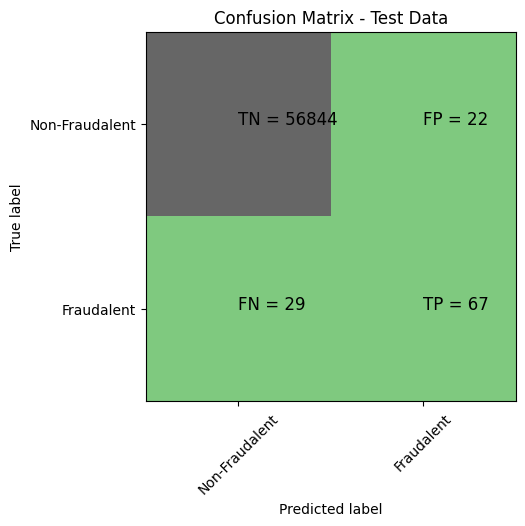

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.75      0.70      0.72        96

    accuracy                           1.00     56962
   macro avg       0.88      0.85      0.86     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------------------
Model Accuracy: 0.9991046662687406
XGBoost PR AUC: 0.7367591072265298
XGBoost Threshold: 0.6190267205238342


In [10]:
# Create XGBoost model with the selected hyperparameters
from xgboost import XGBClassifier

clf = XGBClassifier(
    base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
    colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_delta_step=0, max_depth=3,
    min_child_weight=5, n_estimators=100, n_jobs=1, nthread=None, objective='binary:logistic',
    random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=1.0, verbosity=1)

# Fit on the dataset
clf.fit(X_train_SKF_cv, y_train_SKF_cv)
XGB_test_score = clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print('Confusion Matrix')
plot_confusion_matrix(y_test,y_pred)
print("Classification Report")
print(classification_report(y_test,y_pred))
print('-'*60)
#Probabilities for each class
XGB_probs = clf.predict_proba(X_test)[:,1]

#Calculate precision-recall curve values
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, XGB_probs)

print(f'Model Accuracy: {XGB_test_score}')
# PR AUC for XGBoost model
xgb_pr_auc = auc(recall_xgb, precision_xgb)
print(f'XGBoost PR AUC: {xgb_pr_auc}')

# Find the threshold for maximum F1 score
threshold_xgb = thresholds_xgb[np.argmax(2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb))]
print(f'XGBoost Threshold: {threshold_xgb}')

##**Model Creation (Balanced Data)**

###**Creating common function for models**

In [13]:
# Create a dataframe to store results
df_results = pd.DataFrame(columns=['Methodology','Model','Accuracy','roc_value','threshold'])

In [11]:
# Create a common function to fit and predict on a Logistic Regression model for both L1 and L2
def buildAndRunLogisticModels(df_results, Methodology, X_train, y_train, X_test, y_test):

  # Logistic Regression
  from sklearn import linear_model
  from sklearn.model_selection import KFold

  num_C = list(np.power(10.0, np.arange(-10,10)))
  cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

  searchCV_l2 = linear_model.LogisticRegressionCV(
      Cs= num_C,
      penalty='l2',
      scoring='roc_auc',
      cv=cv_num,
      random_state=42,
      max_iter=10000,
      fit_intercept=True,
      solver='newton-cg',
      tol=10
  )

  searchCV_l1 = linear_model.LogisticRegressionCV(
      Cs=num_C,
      penalty='l1',
      scoring='roc_auc',
      cv=cv_num,
      random_state=42,
      max_iter=10000,
      fit_intercept=True,
      solver='liblinear',
      tol=10
  )

  searchCV_l1.fit(X_train,y_train)
  searchCV_l2.fit(X_train,y_train)
  print('Max auc_roc for l1:', searchCV_l1.scores_[1].mean(axis=0).max())
  print('Max auc_roc for l2:', searchCV_l2.scores_[1].mean(axis=0).max())

  print("Parameters for l1 regularisation")
  print(searchCV_l1.coef_)
  print(searchCV_l1.intercept_)
  print(searchCV_l1.scores_)

  print("Parameters for l2 regularisation")
  print(searchCV_l2.coef_)
  print(searchCV_l2.intercept_)
  print(searchCV_l2.scores_)

  # Find predicted values
  y_pred_l1 = searchCV_l1.predict(X_test)
  y_pred_l2 = searchCV_l2.predict(X_test)

  # Find predicted probabilities
  y_pred_probs_l1 = searchCV_l1.predict_proba(X_test)[:,1]
  y_pred_probs_l2 = searchCV_l2.predict_proba(X_test)[:,1]

  # Accuracy of L2/L1 models
  Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
  Accuracy_l1 = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)

  print('Accuracy of Logistic model with l2 regularisation : {0}'.format(Accuracy_l2))
  print('Confusion Matrix')
  plot_confusion_matrix(y_test,y_pred_l2)
  print('Classification Report')
  print(classification_report(y_test,y_pred_l2))

  print('Accuracy of Logistic model with l1 regularisation : {0}'.format(Accuracy_l1))
  print('Confusion Matrix')
  plot_confusion_matrix(y_test,y_pred_l1)
  print('Classification Report')
  print(classification_report(y_test,y_pred_l1))

  l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
  print("l2 roc_value: {0}".format(l2_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l2 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr,tpr)
  print("ROC for the test dataset", '{:.1%}'.format(roc_auc))

  df_results = df_results.append(pd.DataFrame({'Methodology':Methodology,'Model':'Logistic Regression with L2 Regularisation','Accuracy':Accuracy_l2,'roc_value':l2_roc_value,'threshold':threshold}, index=[0]),ignore_index=True)
  print('-'*60)

  l1_roc_value = roc_auc_score(y_test, y_pred_probs_l1)
  print("l1 roc_value: {0}".format(l1_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l1)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l1 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr,tpr)
  print("ROC for the test dataset", '{:.1%}'.format(roc_auc))

  df_results = df_results.append(pd.DataFrame({'Methodology':Methodology,'Model':'Logistic Regression with L1 Regularisation','Accuracy':Accuracy_l1,'roc_value':l1_roc_value,'threshold':threshold}, index=[0]),ignore_index=True)

  return df_results

In [12]:
# Create a common function to fit and predict on a KNN model
def buildAndRunKNNModels(df_results,Methodology,X_train,y_train,X_test,y_test):

  #create KNN model and fit model with train set
  knn = KNeighborsClassifier(n_neighbors=5, n_jobs=16)
  knn.fit(X_train,y_train)
  score=knn.score(X_test,y_test)
  print('model score')
  print(score)

  #accuracy
  y_pred=knn.predict(X_test)
  KNN_Accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)
  print('Confusion Matrix')
  plot_confusion_matrix(y_test,y_pred)
  print('Classification Report')
  print(classification_report(y_test,y_pred))

  knn_probs= knn.predict_proba(X_test)[:,1]

  #calcualte roc auc
  knn_roc_value = roc_auc_score(y_test, knn_probs)
  print(f'KNN roc_value: {knn_roc_value}')
  fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print(f'KNN threshold {threshold}')

  roc_auc = metrics.auc(fpr,tpr)
  print("ROC for the test data",'{:.1%}'.format(roc_auc))

  df_results = df_results.append(pd.DataFrame({'Methodology':Methodology,'Model':'KNN','Accuracy':score,'roc_value':knn_roc_value,'threshold':threshold},index=[0]),ignore_index=True)

  return df_results

In [14]:
# Create a common function to fit and predict on a DecisionTreeModel for both gini and entropy criteria
def buildAndRunTreeModels(df_results,Methodology,X_train,y_train,X_test,y_test):
  #Evaluate Decision Tree model with 'gini' and 'entropy'
  criteria = ['gini','entropy']
  scores={}

  for c in criteria:
    dt = DecisionTreeClassifier(criterion=c, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    test_score = dt.score(X_test,y_test)
    tree_preds = dt.predict_proba(X_test)[:,1]
    tree_roc_value = roc_auc_score(y_test,tree_preds)
    scores= test_score
    print(c+ f" score: {test_score}")
    print('Confusion Matrix')
    plot_confusion_matrix(y_test, y_pred)
    print('Classification Report')
    print(classification_report(y_test,y_pred))
    print(c + f" tree_roc_value: {tree_roc_value}")
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
    threshold = thresholds[np.argmax(tpr-fpr)]
    print(f"Tree threshold: {threshold}")
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the test dataset", '{:.1%}'.format(roc_auc))

    df_results = df_results.append(pd.DataFrame({'Methodology':Methodology, 'Model':f'DecisionTree Model with {c} criteria', 'Accuracy':test_score,'roc_value':tree_roc_value,'threshold':threshold},index=[0]),ignore_index=True)

  return df_results

In [15]:
# Create a common function to fit and predict on a Random Forest Model
def buildAndRunRandomForestModels(df_results,Methodology,X_train,y_train,X_test,y_test):
  # Evaluate Random Forest Model

  #create the model with 100 trees
  RF_model = RandomForestClassifier(
      n_estimators=100,
      bootstrap = True,
      max_features = 'sqrt', random_state=42)

  #fIt on training data
  RF_model.fit(X_train,y_train)
  RF_test_score= RF_model.score(X_test,y_test)
  RF_model.predict(X_test)

  print(f'Model Accuracy: {RF_test_score}')

  # Actual class predictions
  rf_predictions = RF_model.predict(X_test)

  print("Confusion Matrix")
  plot_confusion_matrix(y_test, rf_predictions)
  print('Classification Report')
  print(classification_report(y_test,rf_predictions))

  #Probabilities for each class
  rf_probs = RF_model.predict_proba(X_test)[:,1]

  #Calculate roc auc
  roc_value = roc_auc_score(y_test, rf_probs)

  print(f"Random Forest roc value: {roc_value}")
  fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print(f"Random Forest threshold: {threshold}")
  roc_auc = metrics.auc(fpr,tpr)
  print("ROC for the test dataset:",'{:.1%}'.format(roc_auc))

  df_results = df_results.append(pd.DataFrame({'Methodology':Methodology, 'Model':'Random Forest', 'Accuracy':RF_test_score,'roc_value':roc_value,'threshold':threshold},index=[0]),ignore_index=True)

  return df_results

In [16]:
# Create a common function to fit and predict on a XGBoost model
def buildAndRunXGBoostModels(df_results,Methodology,X_train,y_train,X_test,y_test):
  #Evaluate XGBoost model
  XGBmodel= XGBClassifier(random_state=42)
  XGBmodel.fit(X_train,y_train)
  y_pred = XGBmodel.predict(X_test)

  XGB_test_score = XGBmodel.score(X_test, y_test)
  print(f'Model Accuracy: {XGB_test_score}')

  print('Confusion Matrix')
  plot_confusion_matrix(y_test,y_pred)
  print("Classification Report")
  print(classification_report(y_test,y_pred))

  #Probabilities for each class
  XGB_probs = XGBmodel.predict_proba(X_test)[:,1]

  #Calcualte roc auc
  XGB_roc_value = roc_auc_score(y_test, XGB_probs)

  print(f'XGBoost roc value: {XGB_roc_value}')
  fpr,tpr,thresholds = metrics.roc_curve(y_test, XGB_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print(f'XGBoost threshold: {threshold}')
  roc_auc = metrics.auc(fpr,tpr)
  print('ROC for the test dataset', '{:.1%}'.format(roc_auc))

  df_results = df_results.append(pd.DataFrame({'Methodology':Methodology, 'Model':'XGBoost', 'Accuracy':XGB_test_score,'roc_value':XGB_roc_value,'threshold':threshold},index=[0]),ignore_index=True)

  return df_results

**Perform class balancing with:**
*   Random Oversampling
*   SMOTE
*   ADASYN (Adaptive Synthetic)

###**Oversampling with RandomOverSampler with StratifiedKFold Cross Validation**

In [19]:
# Accumulating all the feature names under one variable
cols = list(X.columns.values)
# Create the dataset with RandomOverSampler and StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
  X_train = X.loc[train_index]
  y_train = y.loc[train_index]
  X_test = X.loc[test_index]
  y_test = y.loc[test_index]
  ROS = RandomOverSampler(sampling_strategy=0.5)
  X_over, y_over = ROS.fit_resample(X_train, y_train)

X_over = pd.DataFrame(data=X_over, columns = cols)

Logistic Regression with L1 and L2 regularisation
Max auc_roc for l1: 0.5
Max auc_roc for l2: 0.9864632243481092
Parameters for l1 regularisation
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

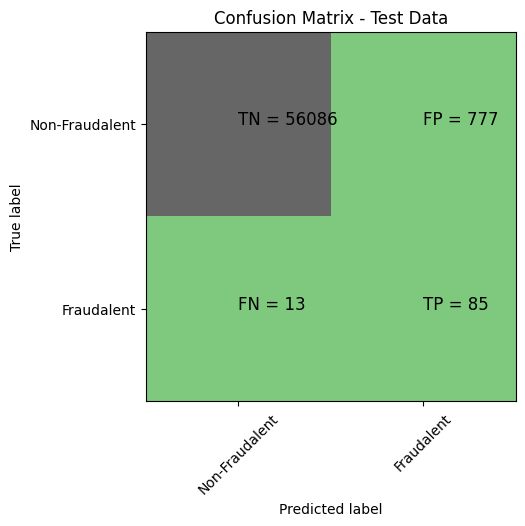

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.10      0.87      0.18        98

    accuracy                           0.99     56961
   macro avg       0.55      0.93      0.59     56961
weighted avg       1.00      0.99      0.99     56961

Accuracy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


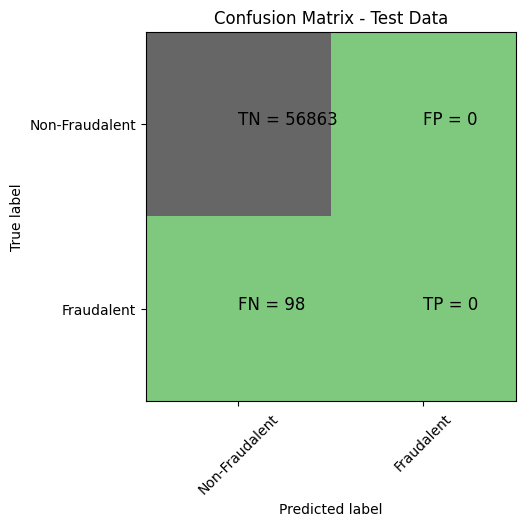

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9809962146756597
l2 threshold: 0.43058708862553374
ROC for the test dataset 98.1%
------------------------------------------------------------
l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%
Time taken by model: ---564.4294703006744 seconds
------------------------------------------------------------
KNN Model
model score
0.9980688541282632
Confusion Matrix


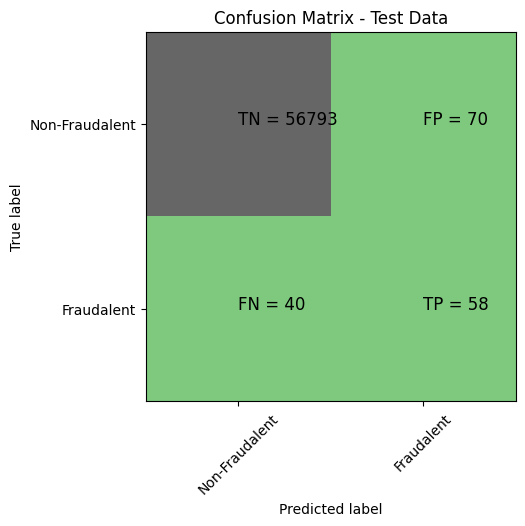

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.45      0.59      0.51        98

    accuracy                           1.00     56961
   macro avg       0.73      0.80      0.76     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc_value: 0.805604465728046
KNN threshold 0.2
ROC for the test data 80.6%
Time taken by model: ---384.29410552978516 seconds
------------------------------------------------------------
Decision Tree Models with gini and entropy criteria
gini score: 0.9989115359632029
Confusion Matrix


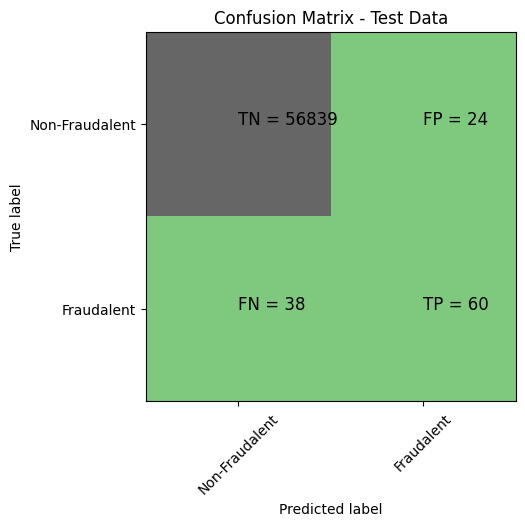

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.71      0.61      0.66        98

    accuracy                           1.00     56961
   macro avg       0.86      0.81      0.83     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8059114154428456
Tree threshold: 1
ROC for the test dataset 80.6%
entropy score: 0.9992275416513052
Confusion Matrix


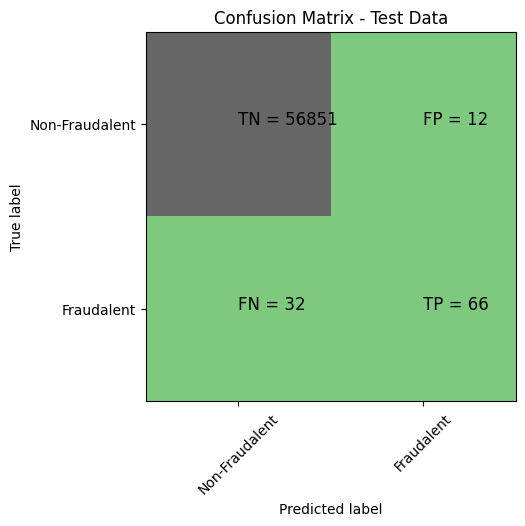

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.85      0.67      0.75        98

    accuracy                           1.00     56961
   macro avg       0.92      0.84      0.87     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.836629177109178
Tree threshold: 1
ROC for the test dataset 83.7%
Time taken by model: ---27.749802350997925 seconds
------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9995084355962852
Confusion Matrix


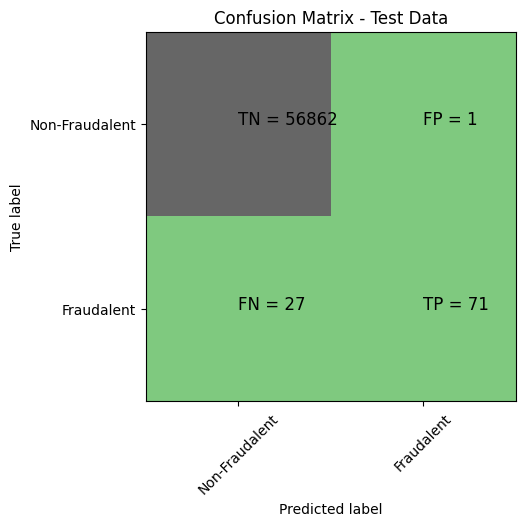

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.72      0.84        98

    accuracy                           1.00     56961
   macro avg       0.99      0.86      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc value: 0.9256681921137342
Random Forest threshold: 0.02
ROC for the test dataset: 92.6%
Time taken by model: ---248.82522296905518 seconds
------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9994557679816014
Confusion Matrix


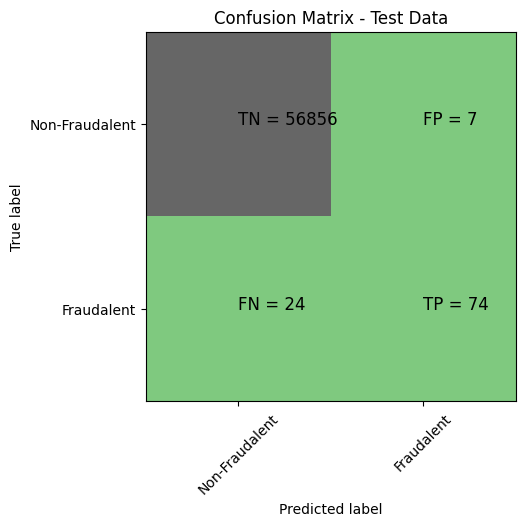

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.76      0.83        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost roc value: 0.9781804602325603
XGBoost threshold: 8.826360135572031e-05
ROC for the test dataset 97.8%
Time taken by model: ---7.581270217895508 seconds
------------------------------------------------------------


In [20]:
# Run Logistic Regression with L1 and L2 regularisation
print('Logistic Regression with L1 and L2 regularisation')
start_time= time.time()
df_results = buildAndRunLogisticModels(df_results,"Random Oversampling with StratifiedKFold CV", X_over, y_over ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run KNN Model
print('KNN Model')
start_time= time.time()
df_results = buildAndRunKNNModels(df_results,"Random Oversampling with StratifiedKFold CV", X_over, y_over ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Decision Tree Models with gini and entropy criteria
print('Decision Tree Models with gini and entropy criteria')
start_time= time.time()
df_results = buildAndRunTreeModels(df_results,"Random Oversampling with StratifiedKFold CV", X_over, y_over ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Random Forest Model
print('Random Forest Model')
start_time= time.time()
df_results = buildAndRunRandomForestModels(df_results,"Random Oversampling with StratifiedKFold CV", X_over, y_over ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run XGBoost Model
print('XGBoost Model')
start_time= time.time()
df_results = buildAndRunXGBoostModels(df_results,"Random Oversampling with StratifiedKFold CV", X_over, y_over ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

###**Oversampling with SMOTE Oversampling**
*   We will use SMOTE Oversampling method to handle the class imbalance

In [21]:
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
  X_train = X.loc[train_index]
  y_train = y.loc[train_index]
  X_test = X.loc[test_index]
  y_test = y.loc[test_index]
  SMOTE = over_sampling.SMOTE(random_state=0)
  X_train_Smote, y_train_Smote = SMOTE.fit_resample(X_train, y_train)

X_train_Smote = pd.DataFrame(data=X_train_Smote, columns = cols)

Logistic Regression with L1 and L2 regularisation
Max auc_roc for l1: 0.5
Max auc_roc for l2: 0.9930151908600335
Parameters for l1 regularisation
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

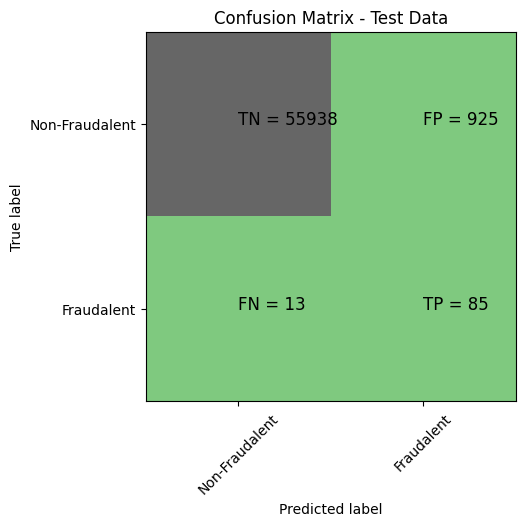

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.08      0.87      0.15        98

    accuracy                           0.98     56961
   macro avg       0.54      0.93      0.57     56961
weighted avg       1.00      0.98      0.99     56961

Accuracy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


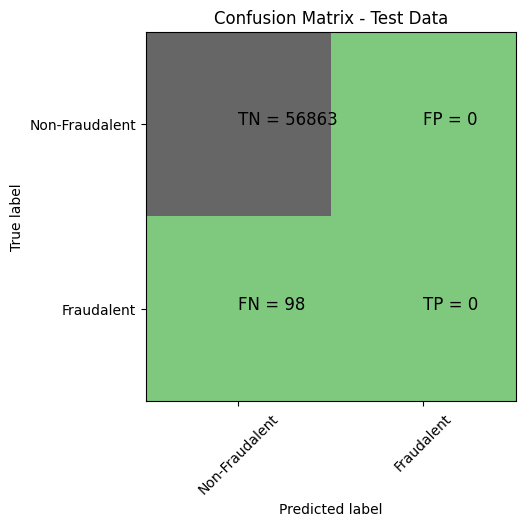

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9745828408918391
l2 threshold: 0.3939516300872773
ROC for the test dataset 97.5%
------------------------------------------------------------
l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%
Time taken by model: ---714.0644288063049 seconds
------------------------------------------------------------
KNN Model
model score
0.9946805709169432
Confusion Matrix


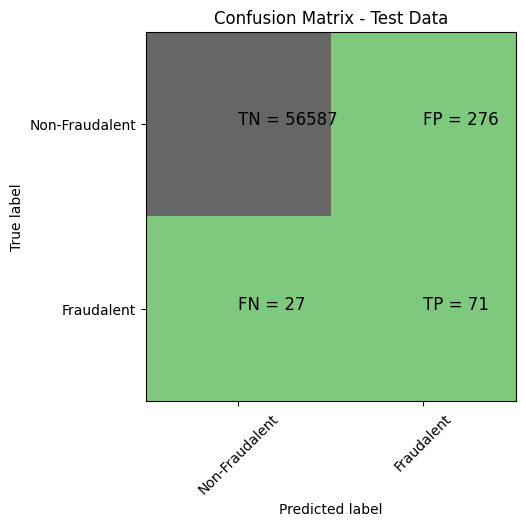

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.20      0.72      0.32        98

    accuracy                           0.99     56961
   macro avg       0.60      0.86      0.66     56961
weighted avg       1.00      0.99      1.00     56961

KNN roc_value: 0.8602674455287628
KNN threshold 0.6
ROC for the test data 86.0%
Time taken by model: ---514.6642465591431 seconds
------------------------------------------------------------
Decision Tree Models with gini and entropy criteria
gini score: 0.9977528484401608
Confusion Matrix


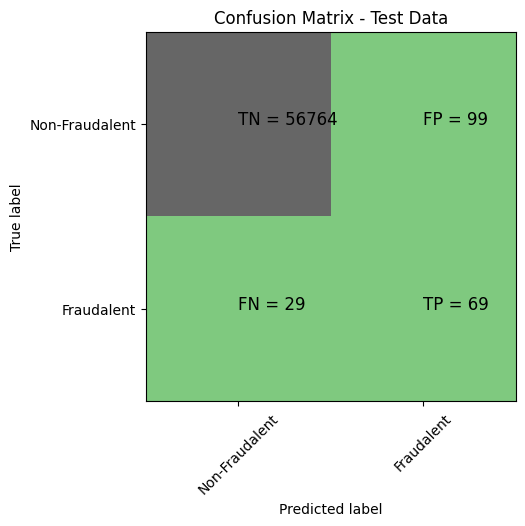

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.41      0.70      0.52        98

    accuracy                           1.00     56961
   macro avg       0.71      0.85      0.76     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8511703029874526
Tree threshold: 1
ROC for the test dataset 85.1%
entropy score: 0.9969803900914661
Confusion Matrix


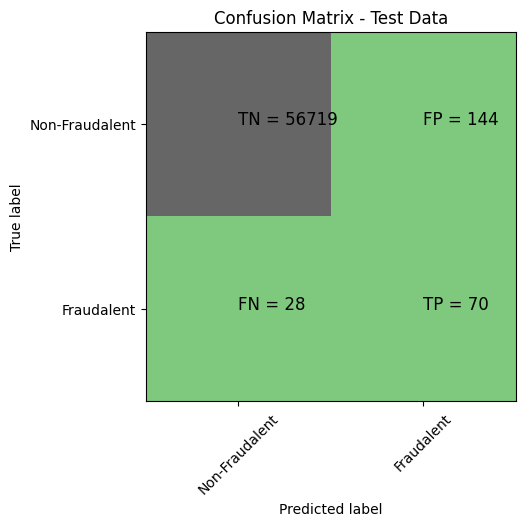

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.33      0.71      0.45        98

    accuracy                           1.00     56961
   macro avg       0.66      0.86      0.72     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8558766559223799
Tree threshold: 1
ROC for the test dataset 85.6%
Time taken by model: ---98.73657655715942 seconds
------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.999490879724724
Confusion Matrix


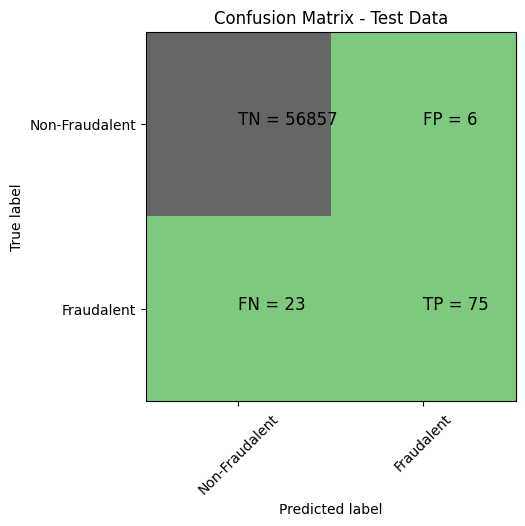

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.77      0.84        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc value: 0.9614705879186172
Random Forest threshold: 0.05
ROC for the test dataset: 96.1%
Time taken by model: ---498.14502930641174 seconds
------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9994031003669177
Confusion Matrix


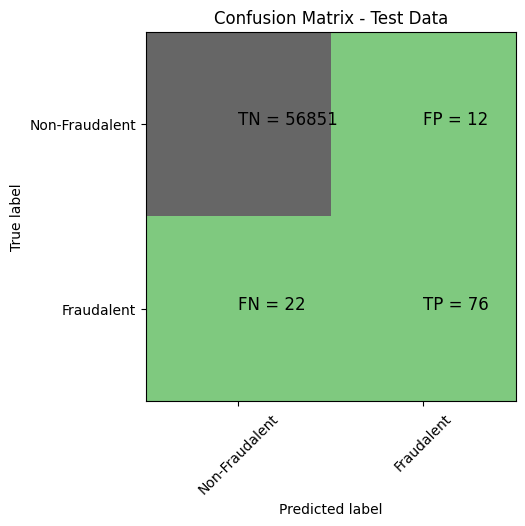

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      0.78      0.82        98

    accuracy                           1.00     56961
   macro avg       0.93      0.89      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost roc value: 0.9704734293344512
XGBoost threshold: 0.000144163059303537
ROC for the test dataset 97.0%
Time taken by model: ---12.041162729263306 seconds
------------------------------------------------------------


In [22]:
# Run Logistic Regression with L1 and L2 regularisation
print('Logistic Regression with L1 and L2 regularisation')
start_time= time.time()
df_results = buildAndRunLogisticModels(df_results,"SMOTE Oversampling with StratifiedKFold", X_train_Smote, y_train_Smote ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run KNN Model
print('KNN Model')
start_time= time.time()
df_results = buildAndRunKNNModels(df_results,"SMOTE Oversampling with StratifiedKFold", X_train_Smote, y_train_Smote ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Decision Tree Models with gini and entropy criteria
print('Decision Tree Models with gini and entropy criteria')
start_time= time.time()
df_results = buildAndRunTreeModels(df_results,"SMOTE Oversampling with StratifiedKFold", X_train_Smote, y_train_Smote ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Random Forest Model
print('Random Forest Model')
start_time= time.time()
df_results = buildAndRunRandomForestModels(df_results,"SMOTE Oversampling with StratifiedKFold", X_train_Smote, y_train_Smote ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run XGBoost Model
print('XGBoost Model')
start_time= time.time()
df_results = buildAndRunXGBoostModels(df_results,"SMOTE Oversampling with StratifiedKFold", X_train_Smote, y_train_Smote ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

###**Oversampling with ADASYN Oversampling**
*   Use ADASYN Oversampling method to handle the class imbalance

In [23]:
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
  X_train = X.loc[train_index]
  y_train = y.loc[train_index]
  X_test = X.loc[test_index]
  y_test = y.loc[test_index]
  ADASYN = over_sampling.ADASYN(random_state=0)
  X_train_ADASYN, y_train_ADASYN = ADASYN.fit_resample(X_train, y_train)

X_train_ADASYN = pd.DataFrame(data=X_train_ADASYN, columns = cols)

Logistic Regression with L1 and L2 regularisation
Max auc_roc for l1: 0.5
Max auc_roc for l2: 0.9835137791366966
Parameters for l1 regularisation
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

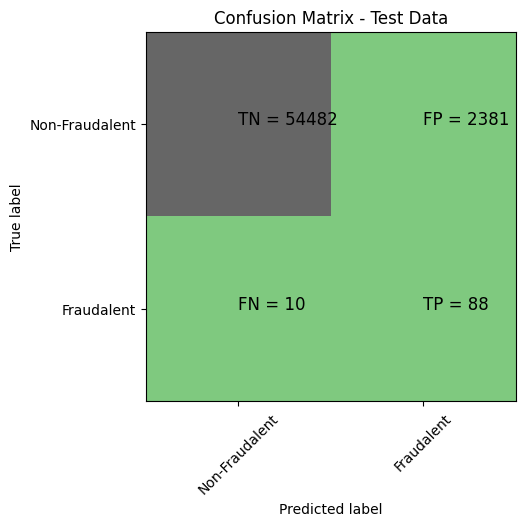

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56863
           1       0.04      0.90      0.07        98

    accuracy                           0.96     56961
   macro avg       0.52      0.93      0.52     56961
weighted avg       1.00      0.96      0.98     56961

Accuracy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


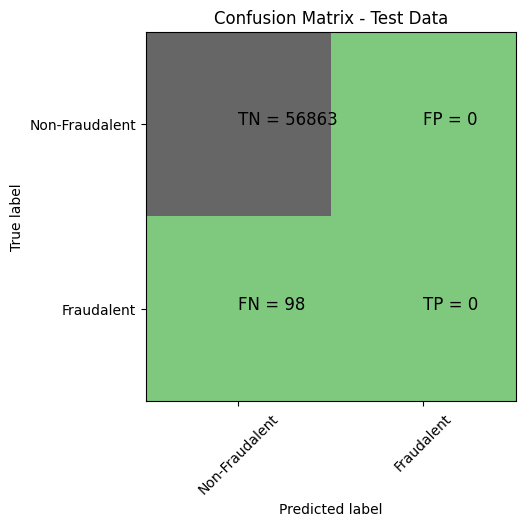

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9740284292321646
l2 threshold: 0.6115468403459997
ROC for the test dataset 97.4%
------------------------------------------------------------
l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%
Time taken by model: ---732.5594575405121 seconds
------------------------------------------------------------
KNN Model
model score
0.9945050122013307
Confusion Matrix


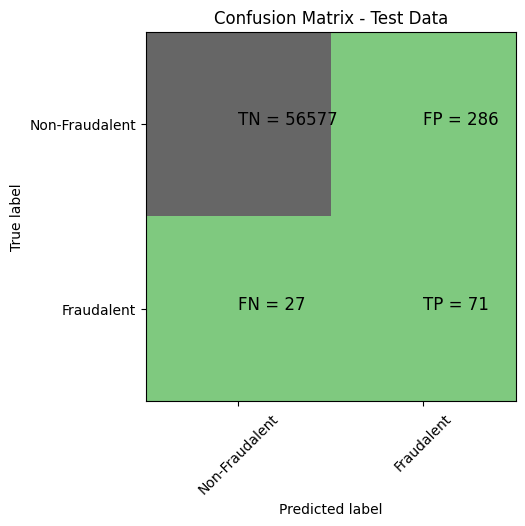

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.20      0.72      0.31        98

    accuracy                           0.99     56961
   macro avg       0.60      0.86      0.65     56961
weighted avg       1.00      0.99      1.00     56961

KNN roc_value: 0.8601937811862167
KNN threshold 0.6
ROC for the test data 86.0%
Time taken by model: ---503.5320339202881 seconds
------------------------------------------------------------
Decision Tree Models with gini and entropy criteria
gini score: 0.9979459630273345
Confusion Matrix


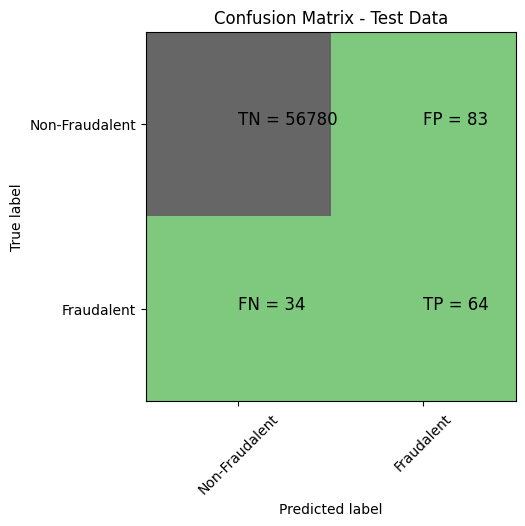

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.44      0.65      0.52        98

    accuracy                           1.00     56961
   macro avg       0.72      0.83      0.76     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8258007879303172
Tree threshold: 1
ROC for the test dataset 82.6%
entropy score: 0.9954179175225154
Confusion Matrix


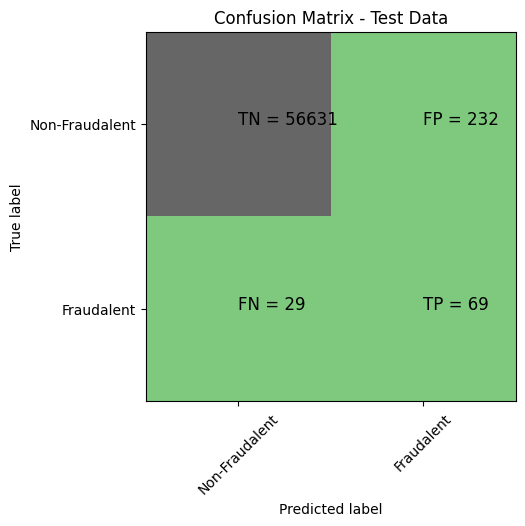

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.23      0.70      0.35        98

    accuracy                           1.00     56961
   macro avg       0.61      0.85      0.67     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8500008254713172
Tree threshold: 1
ROC for the test dataset 85.0%
Time taken by model: ---90.64660358428955 seconds
------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9995259914678464
Confusion Matrix


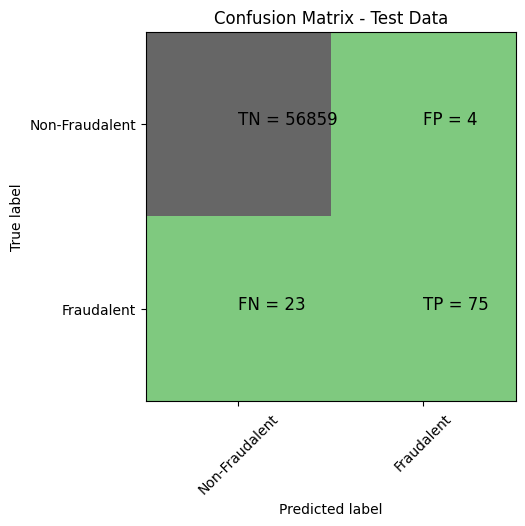

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56961
   macro avg       0.97      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc value: 0.9632269575962563
Random Forest threshold: 0.03
ROC for the test dataset: 96.3%
Time taken by model: ---515.4728031158447 seconds
------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.999350432752234
Confusion Matrix


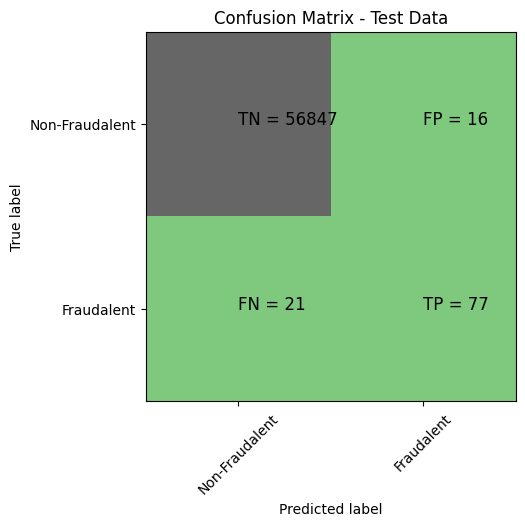

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.83      0.79      0.81        98

    accuracy                           1.00     56961
   macro avg       0.91      0.89      0.90     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost roc value: 0.9696561230052754
XGBoost threshold: 0.00012316476204432547
ROC for the test dataset 97.0%
Time taken by model: ---11.075664758682251 seconds
------------------------------------------------------------


In [24]:
# Run Logistic Regression with L1 and L2 regularisation
print('Logistic Regression with L1 and L2 regularisation')
start_time= time.time()
df_results = buildAndRunLogisticModels(df_results,"ADASYN Oversampling with StratifiedKFold", X_train_ADASYN, y_train_ADASYN ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run KNN Model
print('KNN Model')
start_time= time.time()
df_results = buildAndRunKNNModels(df_results,"ADASYN Oversampling with StratifiedKFold", X_train_ADASYN, y_train_ADASYN ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Decision Tree Models with gini and entropy criteria
print('Decision Tree Models with gini and entropy criteria')
start_time= time.time()
df_results = buildAndRunTreeModels(df_results,"ADASYN Oversampling with StratifiedKFold", X_train_ADASYN, y_train_ADASYN ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Random Forest Model
print('Random Forest Model')
start_time= time.time()
df_results = buildAndRunRandomForestModels(df_results,"ADASYN Oversampling with StratifiedKFold", X_train_ADASYN, y_train_ADASYN ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run XGBoost Model
print('XGBoost Model')
start_time= time.time()
df_results = buildAndRunXGBoostModels(df_results,"ADASYN Oversampling with StratifiedKFold", X_train_ADASYN, y_train_ADASYN ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

In [25]:
df_results = df_results.sort_values('roc_value', ascending=False)
df_results

,Methodology,Model,Accuracy,roc_value,threshold
0,Random Oversampling with StratifiedKFold CV,Logistic Regression with L2 Regularisation,0.986131,0.980996,0.430587
6,Random Oversampling with StratifiedKFold CV,XGBoost,0.999456,0.978180,0.000088
7,SMOTE Oversampling with StratifiedKFold,Logistic Regression with L2 Regularisation,0.983533,0.974583,0.393952
14,ADASYN Oversampling with StratifiedKFold,Logistic Regression with L2 Regularisation,0.958024,0.974028,0.611547
13,SMOTE Oversampling with StratifiedKFold,XGBoost,0.999403,0.970473,0.000144
20,ADASYN Oversampling with StratifiedKFold,XGBoost,0.999350,0.969656,0.000123
19,ADASYN Oversampling with StratifiedKFold,Random Forest,0.999526,0.963227,0.030000
12,SMOTE Oversampling with StratifiedKFold,Random Forest,0.999491,0.961471,0.050000
5,Random Oversampling with StratifiedKFold CV,Random Forest,0.999508,0.925668,0.020000
9,SMOTE Oversampling with StratifiedKFold,KNN,0.994681,0.860267,0.600000


**Conclusion**

The df_results dataframe shows that Logistic Regression with L2 Regularisation using the StratifiedKFold Cross Validation provided the best results (roc_value).

###**Proceeding with the model which shows the best result**

*   Apply the best hyperparameter on the model
*   Predict on the test dataset

In [26]:
# Logistic regression
from sklearn import linear_model
from sklearn.model_selection import KFold

num_C = list(np.power(10.0, np.arange(-10,10)))
cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

clf = linear_model.LogisticRegressionCV(
    Cs=num_C,
    penalty='l2',
    scoring='roc_auc',
    cv=cv_num,
    random_state=42,
    max_iter=10000,
    fit_intercept=True,
    solver='newton-cg',
    tol=10
)

clf.fit(X_train_SKF_cv, y_train_SKF_cv)
print("Max auc_roc for l2:", clf.scores_[1].mean(axis=0).max())

print("Parameters for l2 regularisations")
print(clf.coef_)
print(clf.intercept_)
print(clf.scores_)

# Find predicted values
y_pred_l2 = clf.predict(X_test)

# Find predicted probabilities
y_pred_probs_l2 = clf.predict_proba(X_test)[:,1]

# Accuracy of L2 models
accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)

print(f"Accuracy of Logistic model with l2 regularisation: {accuracy_l2}")

from sklearn.metrics import roc_auc_score
l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
print(f"l2 roc_value: {l2_roc_value}")
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
threshold = thresholds[np.argmax(tpr-fpr)]
print(f"l2 threshold: {threshold}")

Max auc_roc for l2: 0.9824998302436573
Parameters for l2 regularisations
[[ 0.00683334  0.06145934 -0.06703104  0.21837008  0.05400372 -0.0319603
  -0.02280335 -0.1149601  -0.06954056 -0.16366435  0.12779    -0.19159896
  -0.03711445 -0.36059637  0.00364854 -0.08799108 -0.07288165 -0.0007583
   0.00394511 -0.0279599   0.03822224  0.02337054 -0.01173993 -0.00997821
  -0.00657592  0.00627513 -0.01025023 -0.00174467  0.00039791 -0.00096784]]
[-7.40641365]
{1: array([[0.69243733, 0.69420152, 0.71447107, 0.83768575, 0.95579612,
        0.97136042, 0.98915673, 0.99464431, 0.99129517, 0.99071237,
        0.99096601, 0.99096601, 0.99096601, 0.99096601, 0.99096601,
        0.99096601, 0.99096601, 0.99096601, 0.99096601, 0.99096601],
       [0.60700243, 0.60865586, 0.62914551, 0.76884136, 0.90900227,
        0.94879974, 0.9604112 , 0.98181412, 0.98547001, 0.98328227,
        0.97955152, 0.97955152, 0.97955152, 0.97955152, 0.97955152,
        0.97955152, 0.97955152, 0.97955152, 0.97955152, 0.9795

In [29]:
# Create a dataframe for coef values
coefficients = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(clf.coef_))], axis=1)
coefficients.columns = ['Feature','Coefficient Importance']
coefficients

,Feature,Coefficient Importance
0,V1,0.006833
1,V2,0.061459
2,V3,-0.067031
3,V4,0.218370
4,V5,0.054004
5,V6,-0.031960
6,V7,-0.022803
7,V8,-0.114960
8,V9,-0.069541
9,V10,-0.163664


**Print the important features of the best model to understand the dataset**


*   This will not give much explanation on the already transformed data
*   But it will help us understand if the dataset is not PCA transformed

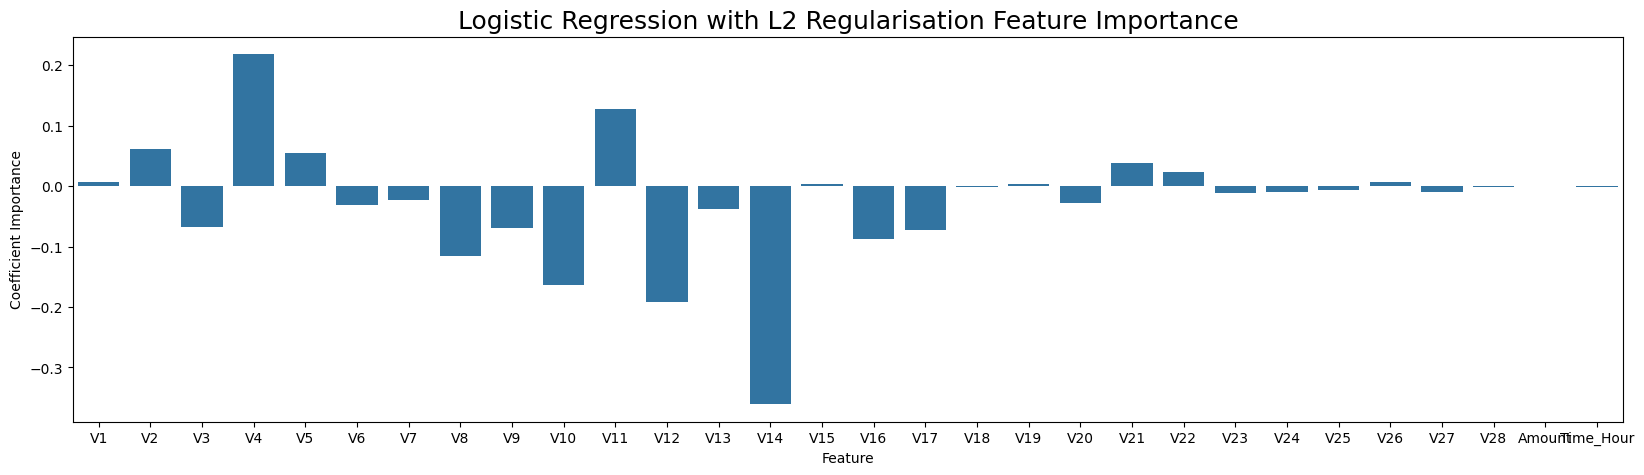

In [30]:
# Plotting the coef values
plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient Importance', data=coefficients)
plt.title('Logistic Regression with L2 Regularisation Feature Importance', fontsize=18)
plt.show()

We observe that V4,V5,V11 has +ve impact whereas V10,V12,V14 seems to have -ve impact on the predictions.